# Introduction
The objective of this project is cover the process of analyzing results of an A/B test conducted to compare the performance of an old website design (Version A) against a new, redesigned version (Version B). The goal of this test is to determine which design leads to higher conversion rates, which is our primary success metric.

## Dataset

- **user_id:** unique user id
- **timestamp:** timestamp of the record
- **group:** control vs. treatment
- **landing_page:** old page vs. new page
- **converted:** 0 vs. 1

## Project Overview

1. **Designing Experiment**
2. **Collect and Prepare Data**
3. **EDA and Visualize A/B Comparison Results** 
4. **Statistical Analysis** 
5. **Conclusion:** 

***
## 1. Designing Experiment

### 1.1 Formulating a hypothesis
**Success Metric**: Conversion rate
##### **Null Hypothesis (H₀)**
The null hypothesis assumes that there is **no difference** in the **conversion rates** between the old design (Version A) and the new design (Version B). Any observed difference in conversion rates between the two designs is due to random chance.
- **H₀**: p = p_0
- **H₀**: Conversion rate of Version A = Conversion rate of Version B

##### **Alternative Hypothesis (H₁)**
The alternative hypothesis assumes that there is a **significant difference** between the **conversion rates** of the two designs, and that the new design (Version B) will lead to a higher conversion rate compared to the old design (Version A).
- **H₁**:p ≠ p_0 
- **H₁**: Conversion rate of Version A ≠ Conversion rate of Version B

#### **Testing and Analysis Approach**
The significance level $\alpha$ value is set to $\alpha=0.05$, which we accept there is a 5% chance that the result is insignificant, or that it just happened by chance alone. Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.

If the p-value is less than 0.05, we can reject the null hypothesis and conclude that the new website design (Version B) significantly improves conversion rates.

---



### 1.2 Define Variables

Since the `group` and `landing_page` are essentially linked (control group = old page, treatment group = new page), they can be used as one **independent variable** representing the experimental condition.

#### 1. **Independent Variable**:
- **Group** (or **Landing Page**): This is the independent variable because it represents the condition in the A/B test, where users are either in the control group (seeing the old landing page) or in the treatment group (seeing the new landing page). Since the `group` and `landing_page` are tied together, you can use either to represent the experimental condition.

#### 2. **Dependent Variable**:
- **Converted**: This is the dependent variable because it shows whether the user converted (1) or did not convert (0). The conversion rate is what you are measuring to see the impact of the different pages (groups).

---

### Summary:
- **Independent Variable**: `group` (control = old page, treatment = new page).
- **Dependent Variable**: `converted` (0 for no conversion, 1 for conversion).

### 1.3 Determine Required Sample Size

#### Steps to Determine Sample Size

1. **Define the Baseline Conversion Rate**: What is the current conversion rate of the control group?

2. **Choose the Minimum Detectable Effect**: Decide the smallest meaningful difference you want to detect between the control and treatment groups.

3. **Set the Statistical Power and Significance Level**: Typically, power is set to 80% (0.8) and significance level to 5% (0.05).

4. **Use a Sample Size Calculator**: Based on these inputs, use a statistical tool or sample size calculator (like the one in Python below) to compute the required sample size.

#### Example:

- **Baseline Conversion Rate**: 10%,  assume current conversion rate of the control group
- **Minimum Detectable Effect**: 2% (from 10% to 12%), and if the conversion rate improved by at least 2% then it is counted as meaningful
- **Power**: Typically, power is set to 80% (0.8) and significance level to 5% (0.05).
- **Significance Level (α)**: 0.05 (5%)

Having set the `power` parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is what we estimated (10% vs. 12%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.


In [6]:
import math
from statsmodels.stats.power import NormalIndPower

# Set parameters
baseline_conversion_rate = 0.10  # 10% conversion rate for control group
minimum_detectable_effect = 0.02  # 2% improvement in conversion rate
alpha = 0.05  # Significance level
power = 0.8   # 80% power

# Calculate effect size
effect_size = minimum_detectable_effect / math.sqrt(baseline_conversion_rate * (1 - baseline_conversion_rate))

# Perform the sample size calculation
sample_size = NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)
print(f"Required sample size per group: {math.ceil(sample_size)}")

Required sample size per group: 3532


We'd need **at least 3532 observations for each group**. 

## 2. Collect and Prepare Data

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [10]:
import zipfile

# Define the zip file and extraction directory
zip_file_path = 'ab_data.csv.zip'
extracted_dir = 'ab_data'

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Load the extracted CSV file into a pandas DataFrame
csv_file_path = f'{extracted_dir}/ab_data.csv'
raw_data = pd.read_csv(csv_file_path)

# Print the number of records
print(f"Number of raw records: {len(raw_data)}")

# Display the first few rows of the data
raw_data.head()

Number of raw records: 294478


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### 2.1 Data Cleaning and Manipulation - To make all users appear only once in the dataset

In [13]:
df=raw_data
# Count how many times each user_id appears in the dataset
user_counts = df['user_id'].value_counts()

# Filter to find users that appear more than once
multiple_appearances = user_counts[user_counts > 1]

# Display the number of users that appear more than once and the actual counts of their appearances
multiple_appearances_count = len(multiple_appearances)
print(f"Number of users that appear more than once: {multiple_appearances_count}")

# Display the first few users who appear multiple times
multiple_appearances.head()

Number of users that appear more than once: 3894


user_id
805339    2
754884    2
722274    2
783176    2
898232    2
Name: count, dtype: int64

##### There are 3894 users appeared more than once, remove them from dataset

In [15]:
# Remove the users who appear more than once
df_cleaned = df[~df['user_id'].isin(multiple_appearances.index)]

# Display the number of rows in the cleaned dataset
cleaned_rows_count = len(df_cleaned)
print(f"Number of rows in the cleaned dataset: {cleaned_rows_count}")

# Optionally, display the first few rows of the cleaned dataset
df_cleaned.head()

Number of rows in the cleaned dataset: 286690


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### 2.2 Data Cleaning and Manipulation - ensure all control group sees old page, and all treatment group sees new page

In [17]:
pd.crosstab(df_cleaned['group'], df_cleaned['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


### 2.3 Sampling
As calculated before sample size for each group `n=3532`, and we set `random_state=42`

In [19]:
# Perform sampling by group, with 3532 observations from each group Control and Treatment
ab_df = df_cleaned.groupby('group').apply(lambda x: x.sample(n=3532, random_state=42)).reset_index(drop=True)

# Display the number of rows in the sampled dataset and the first few rows
sampled_rows_count = len(ab_df)
print(f"Number of rows in the sampled dataset: {sampled_rows_count}")

# Optionally, display the first few rows of the sampled dataset
ab_df.head()

Number of rows in the sampled dataset: 7064


,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0


In [20]:
ab_df['group'].value_counts()

group
control      3532
treatment    3532
Name: count, dtype: int64

## 3. EDA and Visualize A/B Comparison Results

### 3.1 Basic Descriptive Statistics : Control group 11.41% conversion rate, Treatment Group 12.43% conversion rate

In [23]:
# Calculate the conversion rate by group and convert to percentages
conversion_rate_by_group = ab_df.groupby('group')['converted'].mean() * 100

# Display the conversion rates in percentage format
conversion_rate_by_group = conversion_rate_by_group.round(2).astype(str) + '%'
print(conversion_rate_by_group)

group
control      11.41%
treatment    12.43%
Name: converted, dtype: object


In [24]:
ab_df.groupby('group')['converted'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,3532.0,0.114100,0.317977,0.0,0.0,0.0,0.0,1.0
treatment,3532.0,0.124292,0.329961,0.0,0.0,0.0,0.0,1.0


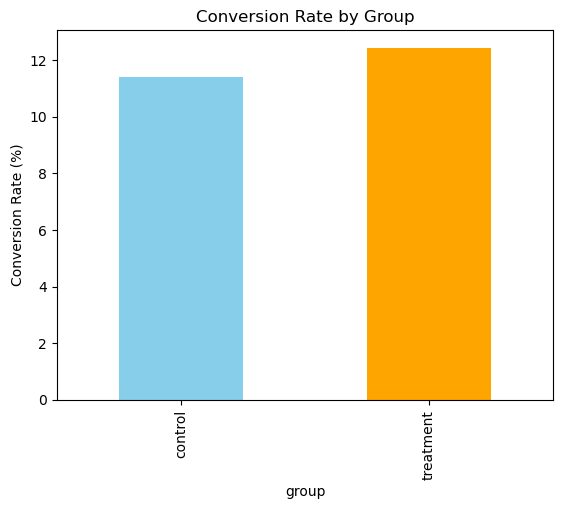

In [25]:
import matplotlib.pyplot as plt
conversion_rate_by_group = ab_df.groupby('group')['converted'].mean() * 100
conversion_rate_by_group.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate (%)')
plt.show()

### 3.2 Distribution of Converted and Not Converted Users

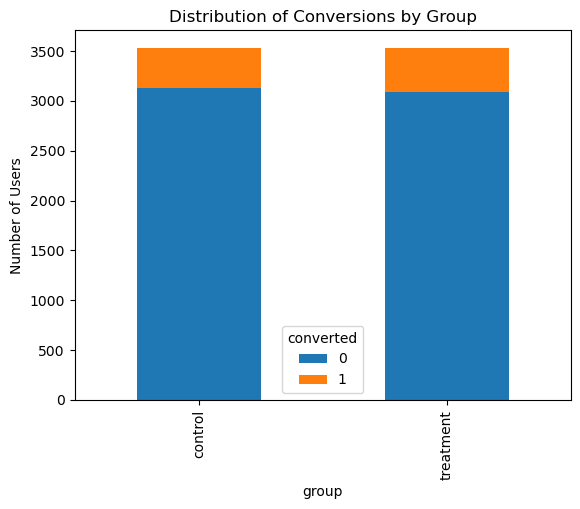

In [27]:
ab_df.groupby(['group', 'converted']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Conversions by Group')
plt.ylabel('Number of Users')
plt.show()

### 3.3 Conversion Rate Over Time

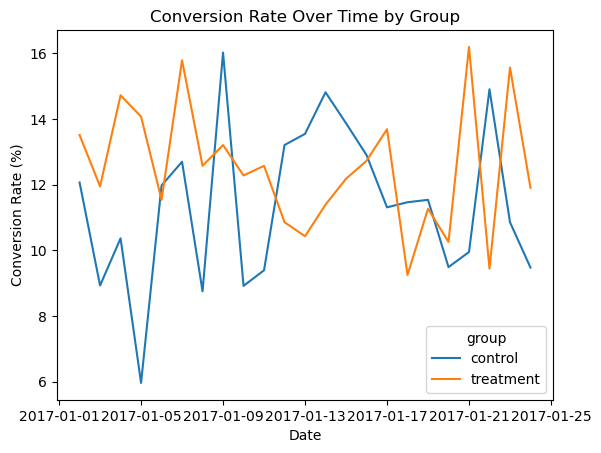

In [29]:
ab_df['date'] = pd.to_datetime(ab_df['timestamp']).dt.date
conversion_by_date = ab_df.groupby(['date', 'group'])['converted'].mean().unstack() * 100
conversion_by_date.plot()
plt.title('Conversion Rate Over Time by Group')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Date')
plt.show()

In [30]:
pd.crosstab(ab_df['group'], ab_df['converted'], margins=True)

converted,0,1,All
group,,,
control,3129,403,3532
treatment,3093,439,3532
All,6222,842,7064


## 4. Statistical Analysis

### 4.1 Z-Test (Proportions Z-Test)
#### The Z-test for proportions compares the conversion rates of two groups (control vs. treatment). The p-value here is derived from the Z-statistic, which measures how far the observed difference between the groups is from the expected difference under the null hypothesis.

In [33]:
from statsmodels.stats.proportion import proportions_ztest

# Number of conversions and total observations in each group
convert_control = ab_df[ab_df['group'] == 'control']['converted'].sum()
n_control = ab_df[ab_df['group'] == 'control']['converted'].count()

convert_treatment = ab_df[ab_df['group'] == 'treatment']['converted'].sum()
n_treatment = ab_df[ab_df['group'] == 'treatment']['converted'].count()

# Z-test
z_stat, p_value_z = proportions_ztest([convert_control, convert_treatment], [n_control, n_treatment])

# Display p-value
print(f"P-value (Z-test): {p_value_z}")

P-value (Z-test): 0.18619314594479486


### 4.2 T-Test (Two-Sample T-Test)
#### The T-test compares the means of two independent groups (in this case, the conversion rates of control and treatment groups) when the sample sizes are small or the population variances are unknown. The p-value in a T-test is derived from the T-statistic, which is calculated based on the means, variances, and sample sizes of both groups.

In [35]:
from scipy import stats

# Conversion data for control and treatment groups
control = ab_df[ab_df['group'] == 'control']['converted']
treatment = ab_df[ab_df['group'] == 'treatment']['converted']

# Two-sample T-test
t_stat, p_value_t = stats.ttest_ind(control, treatment)

# Display p-value
print(f"P-value (T-test): {p_value_t}")

P-value (T-test): 0.18624383323221733


### 4.3  Chi-Square Test
#### The Chi-Square test is used to assess whether there is a relationship between two categorical variables—in this case, the group (control vs. treatment) and whether or not the user converted (0 or 1). The p-value for the Chi-Square test is derived from the Chi-Square statistic.

In [37]:
from scipy.stats import chi2_contingency

# Create a contingency table for the Chi-Square test
contingency_table = pd.crosstab(ab_df['group'], ab_df['converted'])

# Perform the Chi-Square test
chi2_stat, p_value_chi, dof, expected = chi2_contingency(contingency_table)

# Display p-value
print(f"P-value (Chi-Square): {p_value_chi}")

P-value (Chi-Square): 0.19872072507362332


## 5 Conclusion

#### Given that the control group has a conversion rate of 11.41% and the treatment group has a conversion rate of 12.43%, but the p-values from the Z-test, T-test, and Chi-Square test all indicate non-significant results (p-values greater than 0.05), here’s a more detailed insight:


### 1. **Z-Test P-value: 0.186**
- **What it Means**: The Z-test compares the conversion rates of the control and treatment groups. The p-value of **0.186** is greater than the standard alpha level of **0.05**, indicating that the difference in conversion rates between the control (11.41%) and treatment (12.43%) groups is **not statistically significant**.
  
- **Conclusion**: The Z-test suggests that the observed difference in conversion rates could be due to random chance, and there's no strong statistical evidence to conclude that the treatment group (new landing page) performs better than the control group (old landing page).

### 2. **T-Test P-value: 0.186**
- **What it Means**: The T-test is used to compare the means (in this case, the conversion rates) between the two independent groups (control and treatment). The p-value of **0.186** is again higher than the alpha level of **0.05**, suggesting **no significant difference** between the groups.
  
- **Conclusion**: Like the Z-test, the T-test also indicates that the difference between the conversion rates of the control and treatment groups is likely due to random variation, and we **fail to reject the null hypothesis**. The new landing page does not significantly impact conversions.

### 3. **Chi-Square Test P-value: 0.199**
- **What it Means**: The test is used when both variables being analyzed are categorical. For example, in A/B testing, one categorical variable might be the group (control vs. treatment), and the other might be conversion (converted vs. not converted). The p-value of **0.199** is also greater than **0.05**, indicating that the difference in conversions between the control and treatment groups is **not statistically significant**. There is **no relationship** between variables (eg.group and conversion).
  
- **Conclusion**: The Chi-Square test, like the Z-test and T-test, indicates that the assignment to the control or treatment group does not have a significant effect on conversion rates. The observed difference in conversion rates (11.41% vs. 12.43%) is not statistically significant.

---

### **General Insights Based on All Tests:**

1. **P-Values Above 0.05**:
   - All the tests (Z-test, T-test, and Chi-Square) have **p-values above 0.05**. This means that the observed difference in conversion rates between the control and treatment groups is **not statistically significant**.
   - As a result, we **fail to reject the null hypothesis**. The null hypothesis states that there is no difference in conversion rates between the control group (old landing page) and the treatment group (new landing page). The tests suggest that any observed difference (11.41% vs. 12.43%) is likely due to random chance.

2. **Practical Significance vs. Statistical Significance**:
   - While the treatment group has a **1.02% higher conversion rate** (12.43% compared to 11.41%), the **p-values indicate that this difference is not statistically significant**. 
   - From a business perspective, a **1% increase** in conversion rate could be important, especially if you have a large user base. However, without statistical significance, we cannot confidently say that the new landing page is better than the old one.

3. **Lack of Evidence for Treatment Effect**:
   - The p-values from all three tests suggest that there is **insufficient evidence** to conclude that the new landing page has a positive impact on conversions. Any observed improvement could be attributed to random variability rather than a true effect of the new design.

---

### **Next Steps:**

1. **Consider Increasing the Sample Size**:
   - If you believe that even a small difference in conversion rates (like the 1.02% increase) is important, consider running the test with a **larger sample size**. A larger sample size increases the statistical power of the test, potentially detecting smaller but meaningful effects.

2. **Test Other Variants**:
   - If the new page design doesn’t seem to be driving conversions, you might want to consider testing other elements of the page, such as headlines, images, or call-to-action buttons, to see if they have a more significant impact on conversion rates.

3. **Explore Other Metrics**:
   - Besides conversion rates, consider analyzing other metrics, such as **user engagement**, **bounce rate**, or **time spent on the page**. It’s possible that the new design has positive effects on these metrics, even if it doesn’t directly improve conversions.

---

### **Final Takeaway**:
While the treatment group shows a higher conversion rate than the control group (12.43% vs. 11.41%), the p-values indicate that this difference is not statistically significant. The new landing page does **not have a statistically significant impact** on conversion rates compared to the old page. The difference observed between the control and treatment groups is likely due to chance, and there’s no strong evidence to suggest that the new design outperforms the old one in terms of conversions.









